In [1]:
import polars as pl
import scipy.stats as st
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from pathlib import Path
from statannotations.Annotator import Annotator
from itertools import chain
import PyComplexHeatmap as pych

In [2]:
wdir = Path.cwd()

In [3]:
tcga_metadata = (
    pl.read_ipc(wdir.parent / 'Data' / 'clean_clinical.fth')
    .rename({'bcr_patient_barcode': 'barcode'})
    .select('barcode', 'age')
)
hla_alleles = (
    pl.read_ipc(wdir.parent / 'Data' / 'hla_alleles.fth')
    .join(tcga_metadata.filter(pl.col('age') >= 20), on='barcode')
    .drop('age')
)
taa_genes = (
    pl.read_csv(wdir.parent / 'Tables' / 'TableS4.tsv', separator='\t')
    .rename({'Conserved Antigen': 'hgnc', 'Class': 'class'})
)
bpred = pl.read_ipc(wdir.parent / 'Data' / 'taa_netmhcpan_el_ranks.fth')

In [4]:
SCORE_FNS = {
    'strong': (pl.col(pl.Float64) < 0.5).mean(),
    'weak': (pl.col(pl.Float64) < 2).mean(),
}
def get_gene_scores(bpred, score_fn):
    return (
        bpred.lazy()
        .groupby('hgnc')
        .agg(SCORE_FNS[score_fn])
    )

In [5]:
# fgp = fraction gene presentable
scores = get_gene_scores(bpred, 'strong').collect().melt('hgnc', variable_name='allele', value_name='fgp')

In [6]:
def mwu(cols):
    x, y = cols
    res = st.mannwhitneyu(x.to_numpy(), y.to_numpy(), alternative='greater', nan_policy='omit')
    return res.pvalue

Let $P = \{ p_{ij} \}$ be the $\ell \times 6$ matrix of NetMHCPan prediction for a single individual & gene where $\ell$ = number of 8-11mers in the protein. Define global FGP and allele FGP as
$$
\text{global FGP} \coloneqq \frac{\sum_{ij}^{\ell,6} p_{ij} < 0.5}{\ell \cdot 6} \\

[\text{allele FGP}]_j \coloneqq \frac{\sum_{i}^\ell p_{ij} < 0.5}{\ell} \\
$$
then
$$
\begin{align*}
\text{global FGP} &= \frac{\sum_j^6 \sum_{i}^\ell p_{ij} < 0.5}{6 \cdot \ell} \\
&= \frac{\sum_j^6 [\text{allele FGP}]_j}{6} \\
&= \text{mean}(\text{allele FGP})
\end{align*}
$$

In [7]:
rel_diff = (
    hla_alleles.lazy()
    .join(scores.lazy(), on='allele')
    .with_columns(
        # global FGP = mean(allele FGP)
        pl.col('fgp').mean().over(['barcode', 'hgnc']).alias('global_fgp'),
        # global FGP without this specific allele = mean(allele FGP) - this allele FGP / n_alleles
        ((pl.col('fgp').sum().over(['barcode', 'hgnc']) - pl.col('fgp')) / pl.count().over(['barcode', 'hgnc'])).alias('loh_fgp'),
    )
    .with_columns(
        # relative difference = (fgp with loh - fgp) / fgp
        pl.when(pl.col('global_fgp') == 0)
        .then(0)
        .otherwise(
            ((pl.col('loh_fgp') - pl.col('global_fgp')) / pl.col('global_fgp'))
        ).alias('rel_diff'),
        pl.col('allele').str.extract(r'(HLA-[A-Z])').alias('hla_gene'),
    )
    .sort('barcode', 'hgnc')
    .collect()
)
rel_diff.head()

barcode,allele,LOH_status,ai_status,hgnc,fgp,global_fgp,loh_fgp,rel_diff,hla_gene
str,str,bool,bool,str,f64,f64,f64,f64,str
"""TCGA-3N-A9WB""","""HLA-A02:01""",false,false,"""BOLA2""",0.006452,0.004301,0.003226,-0.25,"""HLA-A"""
"""TCGA-3N-A9WB""","""HLA-A02:01""",false,false,"""BOLA2""",0.006452,0.004301,0.003226,-0.25,"""HLA-A"""
"""TCGA-3N-A9WB""","""HLA-B15:01""",false,false,"""BOLA2""",0.0,0.004301,0.004301,0.0,"""HLA-B"""
"""TCGA-3N-A9WB""","""HLA-B39:10""",false,false,"""BOLA2""",0.003226,0.004301,0.003763,-0.125,"""HLA-B"""
"""TCGA-3N-A9WB""","""HLA-C03:03""",false,false,"""BOLA2""",0.006452,0.004301,0.003226,-0.25,"""HLA-C"""


In [8]:
groups = {
    'ai_loh': pl.col('LOH_status') & pl.col('ai_status'),
    'non_ai_loh': pl.col('LOH_status') & ~pl.col('ai_status'),
    'non_loh': ~pl.col('LOH_status'),
}
null_expr = groups['non_loh']
mwu_expr = chain(*[
        (
            (pl.col(f'{name}_median_diff')).first(),
            pl.apply([
                pl.col('rel_diff').filter(null_expr),
                pl.col('rel_diff').filter(test_expr)
            ], mwu).alias(f'{name}_pval'),
        )
        for name, test_expr in groups.items() if not name.endswith('non_loh')
    ])
mwu_results = (
    rel_diff
    .with_columns([
        pl.col('rel_diff').filter(ft).median().over('hgnc').alias(f'{name}_median_diff') for name, ft in groups.items()
    ])
    .groupby('hgnc')
    .agg(pl.col('non_loh_median_diff').first(), *mwu_expr)
    .with_columns(
        [
            pl.col(f'{name}_pval').map(lambda s: pl.Series(multipletests(s.to_numpy(), method='fdr_bh')[1])).alias(f'{name}_fdr_bh')
            for name in groups if not name.endswith('non_loh')
        ]
    )
    .join(taa_genes, on='hgnc')
    .sort('ai_loh_pval')
)
(
    mwu_results
    .select('hgnc', 'class', 'non_loh_median_diff', pl.col(r'^ai.*$'), pl.col(r'^non_ai.*$'))
    .sort('ai_loh_fdr_bh')
    .filter(pl.col('ai_loh_fdr_bh') < 0.05)
)

hgnc,class,non_loh_median_diff,ai_loh_median_diff,ai_loh_pval,ai_loh_fdr_bh,non_ai_loh_median_diff,non_ai_loh_pval,non_ai_loh_fdr_bh
str,str,f64,f64,f64,f64,f64,f64,f64
"""NSMCE3""","""MAGE""",-0.162162,-0.250301,0.000009,0.000746,-0.150943,0.962112,0.9733
"""MTERF3""","""SEGs""",-0.166667,-0.236753,0.000027,0.001164,-0.162162,0.728864,0.84497
"""MAGEF1""","""MAGE""",-0.155172,-0.25,0.000748,0.018656,-0.137255,0.988436,0.988436
"""MTX1""","""SEGs""",-0.15,-0.227784,0.000906,0.018656,-0.13571,0.9427,0.964881
"""GPR89B""","""SEGs""",-0.157895,-0.230587,0.001072,0.018656,-0.162132,0.571426,0.839819
"""MTFR1L""","""SEGs""",-0.162791,-0.215019,0.004062,0.045552,-0.168239,0.45414,0.824332
"""MAGED1""","""MAGE""",-0.156627,-0.197023,0.004143,0.045552,-0.147801,0.904435,0.948022
"""MTFR1""","""SEGs""",-0.138889,-0.219807,0.004189,0.045552,-0.136111,0.606469,0.839819


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..


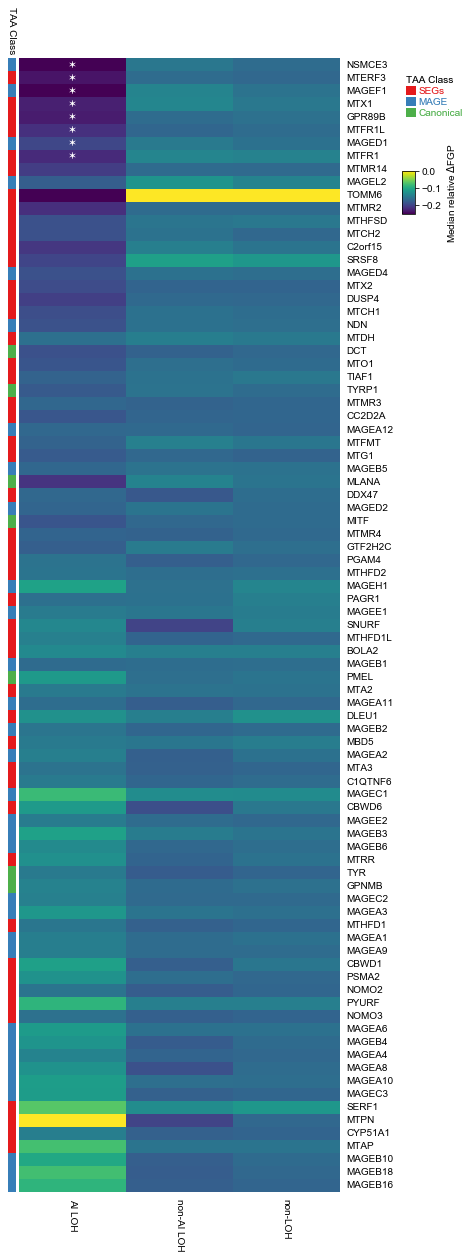

In [11]:
annots = mwu_results.select(
    (pl.col(r'^.*_fdr_bh$') < 0.05).map_dict({True: '✶', False: ''}),
    'hgnc'
).to_pandas().set_index('hgnc')
annots['non_loh'] = ''
annots = annots.rename(columns={
    'ai_loh_fdr_bh': 'AI LOH',
    'non_ai_loh_fdr_bh': 'non-AI LOH',
    'non_loh': 'non-LOH'
})

mwu_plot_data = (
    mwu_results.rename({
        'ai_loh_median_diff': 'AI LOH',
        'non_ai_loh_median_diff': 'non-AI LOH',
        'non_loh_median_diff': 'non-LOH'
    })
    .to_pandas()
    .set_index('hgnc')
)

plt.figure(figsize=(6, 18))

row_ha = pych.HeatmapAnnotation(
    **{
        'TAA Class': mwu_plot_data['class'],
    },
    axis=0,
)

cm = pych.ClusterMapPlotter(
    data=mwu_plot_data[['AI LOH', 'non-AI LOH', 'non-LOH']],
    left_annotation=row_ha,
    vmax=0,
    vmin=-0.25,
    cmap='viridis',
    show_rownames=True,
    show_colnames=True,
    row_cluster=False,
    col_cluster=False,
    label=r'Median relative $\Delta$FGP',
    annot=annots,
    fmt='',
    legend_gap=20,
    yticklabels_kws={'labelsize': 10},
    legend_kws={'ticks': [0, -0.1, -0.2]},
)

In [29]:
rel_diff = rel_diff.with_columns(
    pl.when(pl.col('LOH_status') & pl.col('ai_status'))
    .then('AI LOH')
    .when(pl.col('LOH_status') & ~pl.col('ai_status'))
    .then('non-AI LOH')
    .otherwise('non-LOH')
    .alias('group')
)

non-AI LOH vs. non-LOH: Custom statistical test, P_val:9.733e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:7.460e-04
non-AI LOH vs. non-LOH: Custom statistical test, P_val:8.450e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:1.164e-03
non-AI LOH vs. non-LOH: Custom statistical test, P_val:9.884e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:1.866e-02
non-AI LOH vs. non-LOH: Custom statistical test, P_val:9.649e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:1.866e-02
non-AI LOH vs. non-LOH: Custom statistical test, P_val:8.398e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:1.866e-02
non-AI LOH vs. non-LOH: Custom statistical test, P_val:8.243e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:4.555e-02
non-AI LOH vs. non-LOH: Custom statistical test, P_val:9.480e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:4.555e-02
non-AI LOH vs. non-LOH: Custom statistical test, P_val:8.398e-01
AI LOH vs. non-LOH: Custom statistical test, P_val:4.

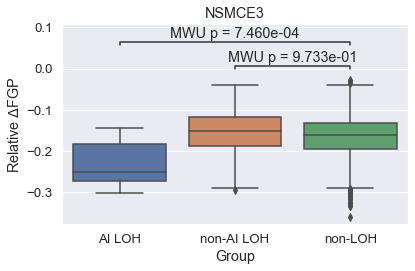

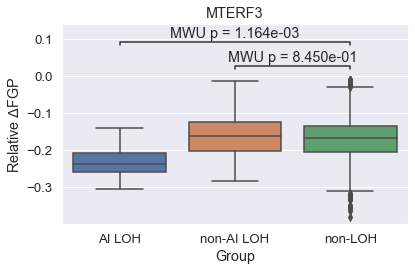

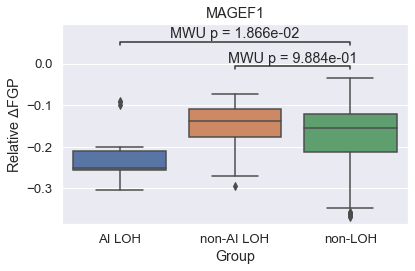

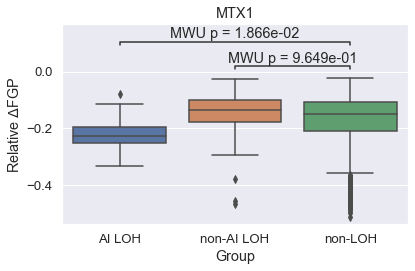

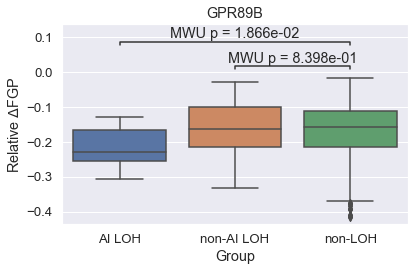

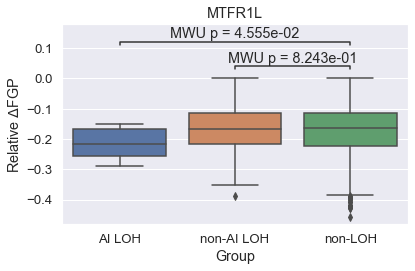

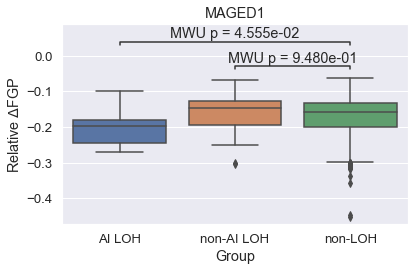

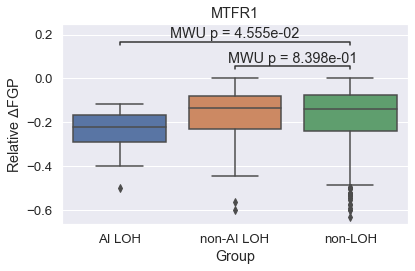

In [30]:
sns.set_theme(font='Arial Unicode MS', font_scale=1.2)
for row in mwu_results.filter(pl.col('ai_loh_fdr_bh') < 0.05).iter_rows():
    gene = row[0]
    gene_rel_diff = rel_diff.filter(pl.col('hgnc') == gene)
    fig = plt.figure()
    ax = sns.boxplot(data=gene_rel_diff.to_pandas(), x='group', y='rel_diff', order=['AI LOH', 'non-AI LOH', 'non-LOH'])
    ax.set(title=gene, ylabel=r'Relative $\Delta$FGP', xlabel='Group')
    
    annotator = Annotator(
        ax,
        [('AI LOH', 'non-LOH'), ('non-AI LOH', 'non-LOH')],
        data=gene_rel_diff.to_pandas(),
        x='group',
        y='rel_diff',
        order=['AI LOH', 'non-AI LOH', 'non-LOH']
    )
    annotator.configure(text_format='full', test_short_name='MWU')
    annotator.set_pvalues_and_annotate([row[-3], row[-2]])
    fig.tight_layout()